# Exercises solutions
## Artificial Inflation of the test set vs Hyperparameters
In this first part of the excercise, the goal is to compare 2 models: one learned by artificially inflating examples on the train set, according to a given *cost_ratio*, while the other one will be trained on the normal train set, but with setting the *cost ratio* hyperparameter of the inference algorithm.

First thing first, we need to import the relevant libraries and the dataset required

In [1]:
from sklearn import tree
import graphviz
from sklearn.datasets import load_iris
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

We then load the dataset and split it into test set and training set

In [2]:
# Load the iris dataset
iris = load_iris()

# Setup seed
rngs = 0
np.random.seed(rngs)

# Create a uniform distribution of indexes
indices = np.random.permutation(len(iris.data))
# Split the dataset
indices_train = indices[:-10]
indices_test = indices[-10:]

X_train = iris.data[indices_train]
X_test = iris.data[indices_test]
y_train = iris.target[indices_train]
y_test = iris.target[indices_test]

### Inflating the dataset
To solve the first point of the exercise, we need to *artificially inflate* the train set. The idea is to create a new train dataset, in which each example is repeated according to its corresponding class cost.
In order to do that, we first specify a cost array, where the $i^{th}$ element corresponds to the cost assigned to the $i^{th}$ class. We then create an array that specify for every element how many times it has to be repeated, which will then be used by the `np.repeat` function. With that function we can inflate the dataset by inflating indexes that corresponds to instances on the training set.

In [3]:
costs = np.array([10, 1, 1])
inflation_factors = costs[y_train]
# ai stands for: artificially inflated
indices_train_ai = np.repeat(indices_train, inflation_factors)

# We now get the real inflated dataset by using inflated indexes
X_train_ai = iris.data[indices_train_ai]
y_train_ai = iris.target[indices_train_ai]

### Defining the models
Essentially 2 models will be trained: one on the *artificially inflated* dataset, while the other one will be trained on the original training set, but with the cost hyperparameter set to match the inflated version.
According to the theory, those models should ouput the same predictions.

In [4]:
seed = 300
impurity_measure = "entropy"
minimum_samples = 5
weights = { i:costs[i] for i in range(0, len(costs)) } # transform costs inot a suitable form for the library

clf_hp = tree.DecisionTreeClassifier(criterion=impurity_measure, random_state=seed, min_samples_leaf=minimum_samples, class_weight=weights)
clf_ai = tree.DecisionTreeClassifier(criterion=impurity_measure, random_state=seed, min_samples_leaf=minimum_samples)

We now train the model and save their predictions on the test set. We then verify if the models output the same results on the test set. 

In [5]:
clf_hp.fit(X_train, y_train)
clf_ai.fit(X_train_ai, y_train_ai)

results_hp = clf_hp.predict(X_test)
results_ai = clf_hp.predict(X_test)

equals = results_hp == results_ai
from functools import reduce
reduce(lambda x, y: x and y, equals, True) # Return True only if all the results are in accordance

True

As we expected, the results are the same for both models.

# Trying to avoid overfitting
This section will cover the solution of the last points of the excercise proposed. We are basically going to train 3 models with different hyperparameters, trying to keep the overfitting as low as possible. Since we already imported the required libraries we are going to skip these steps. Intead, we will start by defining a matrix with different hyperparameters that will be used to train each model.

In [6]:
seed = 300
hyperparameters = [
    {'criterion':'entropy', 'random_state':seed, 'min_samples_leaf':5, 'max_depth':2, 'min_impurity_decrease':0.5, 'max_leaf_nodes':10},
    {'criterion':'entropy', 'random_state':seed, 'min_samples_leaf':3, 'max_depth':2, 'min_impurity_decrease':2, 'max_leaf_nodes':10},
    {'criterion':'entropy', 'random_state':seed, 'min_samples_leaf':4, 'max_depth':3, 'min_impurity_decrease':1, 'max_leaf_nodes':15},
    {'criterion':'entropy', 'random_state':seed, 'min_samples_leaf':4, 'max_depth':3, 'min_impurity_decrease':1, 'max_leaf_nodes':15}
]

Every row of the matrix corresponds to a particular hyperparameters configuration of the model. For each row, we learn a tree model, saving it into a matrix with its results on the test set.

In [7]:
results = []
classifiers = []

for params in hyperparameters:
    clf = tree.DecisionTreeClassifier(**params)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    results.append(predicted)
    classifiers.append(clf)

In order to create the *confusion matrix*, it is necessary to create a specific function `gen_conf_matrix`. The idea is to first consider each class in turn. For every example in the test set, we then check if it corresponds to the current class that is being considered. Then add one to the $k^{th}$ row, that corresponds to the class that has been predicted by the model.
After the definition of the function, we then use it to calculate the confusion matrix for every result of the model.
Alternatively, we can use the appropriate function provided by the *Scikit Learn* library to generate confusion matrices. 

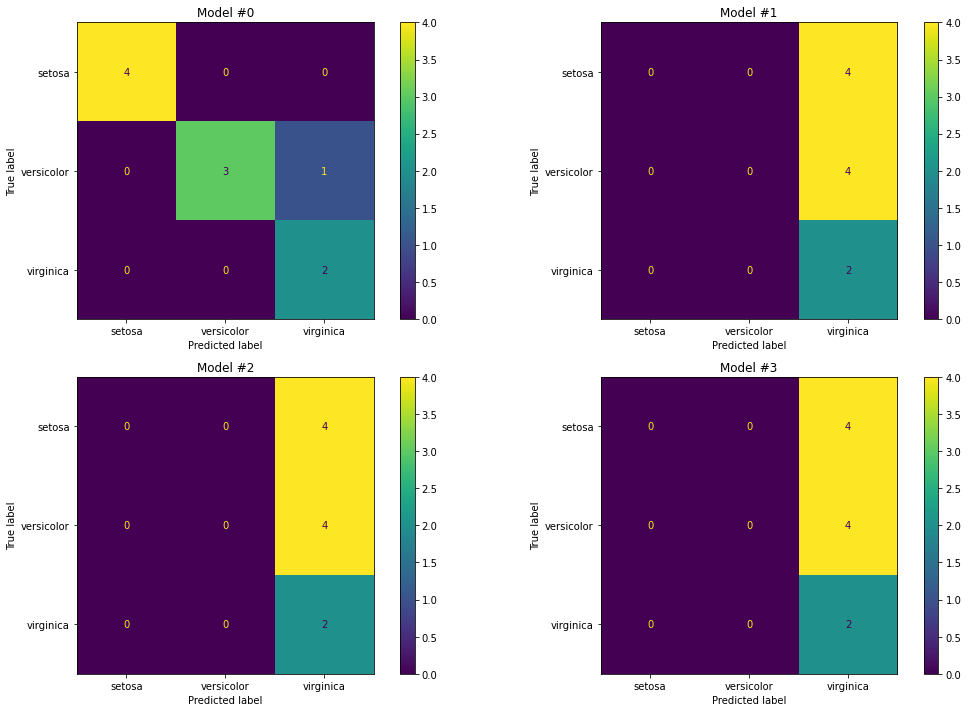

In [8]:
def gen_conf_matrix(y_test, y_predicted, n_classes):
    confusion = np.zeros(shape=(n_classes, n_classes))
    for i in range(0, n_classes):
        for k in range(0, len(y_test)):
            if(y_test[k] == i):
                confusion[i][y_predicted[k]] += 1
    return confusion

# Define a list to store confusion matrices
confusion_matrices = []
# Vanilla method
# for r in results:
#     cm = gen_conf_matrix(y_test, r, len(iris.target_names))
#     confusion_matrices.append(cm)

# Alternative (better) method which uses the appropriate sklearn function 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a subplot that will contain each confusion matrix
# (taken from https://stackoverflow.com/questions/61016110/plot-multiple-confusion-matrices-with-plot-confusion-matrix)
f, axes = plt.subplots(2, 2, figsize=(15, 10))

for ax, (i, r) in zip(axes.flatten(), enumerate(results)):
    cm = confusion_matrix(y_test, r)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=iris.target_names)
    disp.plot(ax=ax)
    ax.title.set_text("Model #" + str(i))
plt.tight_layout()  
plt.show()

In order to print the actual ROC plot for every model, we first need to retrieve the empirical probabilities for each node of the tree. So we define a function that traverse the tree model in a depth first fashion, returning every empirical probability in a list.

In [ ]:
# Learn a classifier and reduce overfitting
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state=seed, min_samples_leaf=5, max_depth=2, min_impurity_decrease=0.5, max_leaf_nodes=10)

